In [1]:
import sys
from time import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.append("..")
from dataset import Pipeline, DatasetIndex, Dataset, B, C, F, V

from linknet import LinkNetModel                                  # TFModel subclass with LinkNet
from nmnist import NoisedMnist                                          # Batch subclass with loading and noise actions
from plot_functions import plot_noised_image, plot_examples_highlighted # plot functions to demonstrate result 

%matplotlib inline

In [2]:
BATCH_SIZE = 256   # batch size for NN training
MAX_ITER = 100     # number of iterations for NN training
SIZE = 50000
IMAGE_SIZE = 64

In [3]:
images = []
masks = []
for i in tqdm(range(SIZE)):
    data = np.sin(np.random.uniform(0, 2*np.pi) + np.arange(0, IMAGE_SIZE) / IMAGE_SIZE * 2*np.pi )
    mask = data > 0.25
    images.append(data)
    masks.append(mask)
images = np.array(images)
masks = np.array(masks)
masks = np.stack([1-masks, masks], axis=2)

100%|█████████████████████████████████| 50000/50000 [00:01<00:00, 49847.59it/s]


In [4]:
ind = DatasetIndex(np.arange(SIZE))          # index for images
dset = Dataset(ind, batch_class=NoisedMnist)   # Dataset with transform actions in NoisedMnist class
dset.cv_split([0.9, 0.1])                      # divide it into train and test

In [5]:
load_template = Pipeline().load(src=(images, masks), components=('images', 'masks'))

In [6]:
train_feed_dict = {'input_image': B('images'),
                   'targets': B('masks')
                  }        

test_feed_dict = {'input_image': B('images'),
                  'targets': B('masks')
                 }

In [7]:
ppl_train = ((load_template << dset.train)
            .init_variable('train_loss_history', init_on_each_run=list)
            .init_model('static',                                          # model mode
                        LinkNetModel,                                      # TFModel subclass with LinkNet
                        'linknet',                                         # model name
                        config={'loss': 'softmax_cross_entropy',
                                'optimizer': 'Adam',
                                'n_classes': 2,
                                'dim': 1,
                                'b_norm': False, 
                                'images_shape': (IMAGE_SIZE, )})
            .train_model('linknet',                                        # model name
                         fetches='loss',                                   # tensors to get value 
                         feed_dict=train_feed_dict,                        
                         append_to=V('train_loss_history')))                  # name of pipeline variable to save loss value

ppl_test = ((load_template << dset.test)
            .import_model('linknet', ppl_train)
            .init_variable('test_loss_history', init_on_each_run=list)
            .predict_model('linknet', 
                           fetches='loss',
                           feed_dict=test_feed_dict,
                           append_to=V('test_loss_history')))

In [8]:
# training of the model

start = time()

for i in range(MAX_ITER):
    ppl_train.next_batch(BATCH_SIZE, n_epochs=None)                              # training step
    ppl_test.next_batch(100, n_epochs=None)                                      # compute test loss
    
    train_loss = ppl_train.get_variable('train_loss_history')[-1]                # get current iteration train loss
    test_loss = ppl_test.get_variable('test_loss_history')[-1]                   # get current iteration test loss
    
    if (i+1) % 10 == 0:
        print("Iter {:3d}: train {:05.3f} test {:05.3f}".format(i+1, train_loss, test_loss))
        
stop = time()

print("Train time: {:05.3f} min".format((stop-start)/60))

Iter  10: train 1.120 test 1.027
Iter  20: train 0.693 test 0.666
Iter  30: train 0.277 test 0.206
Iter  40: train 0.075 test 0.059
Iter  50: train 0.041 test 0.044
Iter  60: train 0.037 test 0.037
Iter  70: train 0.032 test 0.025
Iter  80: train 0.020 test 0.028
Iter  90: train 0.023 test 0.022
Iter 100: train 0.026 test 0.017
Train time: 6.110 min


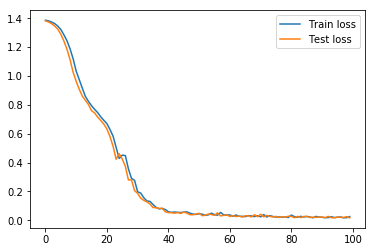

In [14]:
plt.plot(ppl_train.get_variable('train_loss_history'), label='Train loss')
plt.plot(ppl_test.get_variable('test_loss_history'), label='Test loss')
plt.legend()
plt.show()

In [15]:
images = []
masks = []
noise = []

ppl_plot = ((load_template << dset.test)
             .import_model('linknet', ppl_train)
             .init_variable('predictions', init_on_each_run=list)
             .predict_model('linknet',                                      
                           fetches='prob_predictions',
                           feed_dict=test_feed_dict,
                           append_to=V('predictions')))

In [16]:
ppl_plot.next_batch(10, n_epochs=None)
predictions = ppl_plot.get_variable('predictions')[-1]